<a href="https://colab.research.google.com/github/FatihMercan61/Deep-Learning-In-Production/blob/master/Xgboost_BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# verbindung zu drive herstellen
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Data/industrie_data.csv")

# Ausführen

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 12.8 MB/s 
     |████████████████████████████████| 209 kB 66.6 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 78 kB 8.7 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 112 kB 71.2 MB/s 
     |████████████████████████████████| 147 kB 64.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=73dde5952e64ecf89abf898589c63f790abac18a35fb850021d9a14599d76d9e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


## eigene Funktionen

In [ ]:
# wichtigeste Bibliptheken
import optuna
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.samplers import TPESampler
import time
import joblib
from time import localtime
import os

# sonstige importe 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
import xgboost as xgb
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Funktion für split methode
import more_itertools
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit

# sonstige importe
%matplotlib inline

In [ ]:
# folder für study
base_path = r"/content/drive/MyDrive/Optuna_studies"
tag_monat = time.strftime("%d.%b", localtime())
notebook_name = f"XGboost/{tag_monat}"

def path_erzeuger(basepath, anzuhängender_foldername):
  anzuhängender_foldername_path = os.path.join(basepath, anzuhängender_foldername)
  os.makedirs(anzuhängender_foldername_path, exist_ok = True)
  return anzuhängender_foldername_path

notebook_path = path_erzeuger(basepath=base_path, anzuhängender_foldername=notebook_name)
notebook_path

'/content/drive/MyDrive/Optuna_studies/XGboost/23.Nov'

In [ ]:
# save optuna study
def speicher_study(directory, study):
  tag_monat_uhrzeit=time.strftime("%d.%b_um_%Hh_%Mm", localtime())
  study_path=os.path.join(directory,f"Acc_{study.best_trial.value:.2f}_{tag_monat_uhrzeit}.pkl")
  joblib.dump(study,study_path)

In [ ]:
class schrift:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   DICK = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
# unnötige Klassen und Funktionen
def angebe_set_shapes(X_train, y_train, X_val, y_val, X_test, y_test):
  print("Train")
  print("--> X_train: ",X_train.shape)
  print("--> y_train: ",y_train.shape, "\n")
  print("Validation")
  print("--> X_val: ",X_val.shape)
  print("--> y_val: ",y_val.shape,"\n")
  print("Test")
  print("--> X_test: ",X_test.shape)
  print("--> y_test: ",y_test.shape,"\n")

In [ ]:
def plotte_acc_ergebnisse(train_acc_list, val_acc_list):
  print(schrift.GREEN, schrift.DICK, schrift.UNDERLINE, "Train ",schrift.END, "\n")  
  print(schrift.RED, schrift.DICK,"Train max accuracy: ", schrift.END, np.amax(train_acc_list), "\n")
  print(schrift.RED, schrift.DICK,"index of max value: ", schrift.END,  np.argmax(train_acc_list), "\n")
  print(schrift.RED, schrift.DICK,"mean accuracy: ", schrift.END, np.mean(train_acc_list))

  print(schrift.BLUE, schrift.DICK, schrift.UNDERLINE, "Validation ", schrift.END,"\n")  
  print(schrift.RED, schrift.DICK,"Validation max accuracy: ", schrift.END, np.amax(val_acc_list), "\n")
  print(schrift.RED, schrift.DICK,"index of max value: ", schrift.END,  np.argmax(val_acc_list), "\n")
  print(schrift.RED, schrift.DICK,"mean accuracy: ", schrift.END, np.mean(val_acc_list))

  plt.figure(figsize=(15,10))
  plt.plot(train_acc_list, "g", label = "Train Accuracy")
  plt.plot(np.repeat(np.mean(train_acc_list),len(train_acc_list)), "g--")
  plt.plot(val_acc_list, "b", label = "Validation Accuracy")
  plt.plot(np.repeat(np.mean(val_acc_list),len(val_acc_list)), "b--")
  plt.legend(fontsize="medium")

In [ ]:
def validate(model, X_data, y_data):
  # AUC
  scores = cross_val_score(model, X_data, y_data, scoring = "roc_auc_ovr", cv = 10)

  # Confusion Matirx
  predictions= cross_val_predict(model,X_data, y_data, cv = 10)
  conf_matrix = confusion_matrix(y_data,predictions)

  # Report für recall/precision/accuracy/f1
  report = classification_report(y_data,predictions)

  # print alles
  print("AUC scores: \n", scores.mean(), "\n")
  print("Classification report: \n", report, "\n")
  print("Confusion Matrix: \n", conf_matrix)
  sns.heatmap(conf_matrix)

In [ ]:
# Ergebnisse nach study
def ergebnis(study, trial_ergebnisse=True, overfitting_test=True, slice_plot=True, param_importance=True, speichern = True, directory = notebook_path):
  # trial werte
  if trial_ergebnisse:
    trial = study.best_trial
    print(schrift.BLUE, schrift.DICK,"Ergebnisse der Study: ", schrift.END, "\n")
    print(schrift.RED, schrift.DICK,"Accuracy of best model: ", schrift.END, trial.value, "\n")
    print(schrift.RED, schrift.DICK,"Best Hyperparameters: ", schrift.END, trial.params, "\n")

  # Overfitting Test
  if overfitting_test:
    model = xgb.XGBClassifier(use_label_encoder=False, val_metric='mlogloss',seed = 0)  # model initialisieren mit randomstate=0 ändern!!!
    params = study.best_trial.params
    model.set_params(**params)
    model.fit(X_train,y_train)
    prediction_main = model.predict(X_train)
    prediciton_test = model.predict(X_val)
    acc_main = accuracy_score(y_train, prediction_main)
    acc_test = accuracy_score(y_val, prediciton_test)
    print(schrift.BLUE, schrift.DICK,"Overfitting Test : ", schrift.END, "\n")
    print(schrift.RED, schrift.DICK,"Train acc: ",schrift.END,acc_main, "\n")
    print(schrift.RED, schrift.DICK,"Test acc: ", schrift.END, acc_test)

  # optuna plot
  if slice_plot:
    fig = optuna.visualization.plot_slice(study)
    fig.show()
  if param_importance:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

  if speichern:
    speicher_study(directory, study)

In [ ]:
# Funktion für split
import more_itertools
from sklearn.model_selection import StratifiedShuffleSplit

# Hinweis: in die Funktion nur Dataframes einsetzen
def split_in_groß_klein_set(dataframe_was_gesplittet_werden_soll, größe_der_kleinen_gruppen = 0.2, spaltenname_nach_der_gesplittet_werden_soll="main-test-result"):
  dataframe_was_gesplittet_werden_soll = shuffle(dataframe_was_gesplittet_werden_soll)
  aufteilungsgruppen = dataframe_was_gesplittet_werden_soll[spaltenname_nach_der_gesplittet_werden_soll].copy()
  aufteilung = StratifiedShuffleSplit(n_splits=1, test_size=größe_der_kleinen_gruppen, random_state=0)

  rückgabe_objekt_der_split_methode = aufteilung.split(dataframe_was_gesplittet_werden_soll, aufteilungsgruppen)
  großer_set_id, kleiner_set_id = more_itertools.one(rückgabe_objekt_der_split_methode)
  großer_set = dataframe_was_gesplittet_werden_soll.iloc[großer_set_id]
  kleiner_set = dataframe_was_gesplittet_werden_soll.iloc[kleiner_set_id]
  return großer_set ,kleiner_set

In [ ]:
class MeinScaler(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.min = None
    self.max = None
    self.is_fitted = False

  def fit(self, data):
    data = np.asarray(data)
    self.min = np.min(data)
    self.max = np.max(data)
    self.is_fitted= True

  def transform(self, data):
    data = np.asarray(data)
    return (data - self.min) / (self.max - self.min) 

In [ ]:
# overfitting test
def overfitting_test(model, X_train, y_train, X_val, y_val):
  model.fit(X_train,y_train)
  prediction_main = model.predict(X_train)
  prediciton_test = model.predict(X_val)
  acc_main = accuracy_score(y_train, prediction_main)
  acc_test = accuracy_score(y_val, prediciton_test)
  print("Train acc: ",acc_main)
  print("Test acc: ", acc_test)

In [ ]:
def optimize_speicher(study,note_bookpath=notebook_path, trialanzahl_pro_study=1000, anzahl_wiederholungen=1, plotte_nach_iter_iteration=2):
  for i in range(anzahl_wiederholungen):
    if i == plotte_nach_iter_iteration:
      plotte_acc_ergebnisse(train_acc_list, val_acc_list)
    study.optimize(objective, n_trials=trialanzahl_pro_study)
    speicher_study(notebook_path, study)
    print(schrift.RED, schrift.DICK,"Gespeichert", schrift.END,"\n")

## DataPreprocessing

In [ ]:
df.head()

,NR,id,variant,main-test-result,mame1
0,0,125050104S02_221115194628,125050104S02,passed,"4183, 3067, 1394, 2509, 3625, 2788, 3067, 1952..."
1,1,125050104S02_221115194435,125050104S02,passed,"5578, 1673, 3346, 3904, 3625, 3625, 3346, 3346..."
2,2,125050104S02_221115194428,125050104S02,passed,"5020, 4183, 2509, 1952, 4183, 3346, 3904, 3346..."
3,3,125050104S02_221115194355,125050104S02,passed,"4183, 6135, 3346, 2231, 3904, 3904, 3346, 3346..."
4,4,125050104S02_221115194331,125050104S02,passed,"5020, 4462, 1952, 2509, 3904, 3625, 3904, 2788..."


In [ ]:
variante1= (df["variant"]=="125050104S02")
df= df[variante1]
df

,NR,id,variant,main-test-result,mame1
0,0,125050104S02_221115194628,125050104S02,passed,"4183, 3067, 1394, 2509, 3625, 2788, 3067, 1952..."
1,1,125050104S02_221115194435,125050104S02,passed,"5578, 1673, 3346, 3904, 3625, 3625, 3346, 3346..."
2,2,125050104S02_221115194428,125050104S02,passed,"5020, 4183, 2509, 1952, 4183, 3346, 3904, 3346..."
3,3,125050104S02_221115194355,125050104S02,passed,"4183, 6135, 3346, 2231, 3904, 3904, 3346, 3346..."
4,4,125050104S02_221115194331,125050104S02,passed,"5020, 4462, 1952, 2509, 3904, 3625, 3904, 2788..."
...,...,...,...,...,...
28837,28837,125050104S02_221005230707,125050104S02,passed,"3346, 278, 1115, 1952, 5020, 6972, 7530, 5857,..."
28838,28838,125050104S02_221005230700,125050104S02,passed,"2231, 2788, 278, 0, 2788, 1673, 1394, 1394, 13..."
28839,28839,125050104S02_221005230627,125050104S02,passed,"2788, 2231, 557, 836, 1673, 1394, 1673, 2231, ..."
28840,28840,125050104S02_221005230620,125050104S02,passed,"1673, 4741, 1952, 1115, 2788, 3067, 2231, 2231..."


In [ ]:
y_data = df["main-test-result"]
X_data = df["mame1"].str.split(",",expand=True) # meme spalte in mehrere spalten splitten
X_data = X_data.iloc[:,:92] # punkte mit NaN rauslöschen
X_data

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,4183,3067,1394,2509,3625,2788,3067,1952,2788,3904,...,307651,300399,299562,308487,300678,302072,301235,305698,302909,300399
1,5578,1673,3346,3904,3625,3625,3346,3346,3904,4462,...,299562,298725,307930,304304,296494,302909,306814,299283,299283,306535
2,5020,4183,2509,1952,4183,3346,3904,3346,3067,4183,...,306814,305698,301514,310440,307372,300399,307372,312392,301235,304583
3,4183,6135,3346,2231,3904,3904,3346,3346,3067,3625,...,305698,304861,303467,302630,305698,303467,301235,303746,304583,302630
4,5020,4462,1952,2509,3904,3625,3904,2788,2788,4183,...,305977,296494,302351,305698,301793,299283,304025,301793,300678,301793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28837,3346,278,1115,1952,5020,6972,7530,5857,6135,5857,...,306535,300399,302630,305698,302630,300120,304583,304304,300957,302630
28838,2231,2788,278,0,2788,1673,1394,1394,1394,1394,...,309324,306535,304583,308488,307930,305977,305419,309324,305140,305698
28839,2788,2231,557,836,1673,1394,1673,2231,1394,1673,...,304583,300120,299004,304583,303467,298167,300678,303467,301514,299841
28840,1673,4741,1952,1115,2788,3067,2231,2231,2231,2788,...,303188,304304,303746,302072,304862,303746,302630,303188,303746,302351


In [ ]:
#def plot_graphen(dataframe, x_range = 88, color = "g", figsize=(15,10), label=None):
#    x_achse = np.arange(x_range)
#    y_achse = dataframe.astype(float)
#    y_achse = np.array(y_achse).T
#    plt.figure(figsize=figsize)
#    plt.plot(x_achse, y_achse, c = color, label = label)

#plot_graphen(dataframe = X_data , x_range = 92, color = "g", figsize=(15,10), label=None)

In [ ]:
# OVERSAMPLING
from imblearn.over_sampling import SMOTE
smote = SMOTE()

X_data, y_data = smote.fit_resample(X_data.astype("float"), y_data)

In [ ]:
#Split in Sets
df = pd.concat([X_data, y_data], axis =1)
main_set, test_set = split_in_groß_klein_set(df)
train_set, val_set = split_in_groß_klein_set(main_set)

In [ ]:
# Split in train, val, test daten
# train data
X_train = train_set.iloc[:,:-1]
y_train = train_set["main-test-result"].copy() 

# validation data
X_val = val_set.iloc[:,:-1]
y_val = val_set["main-test-result"].copy() 

# test data
X_test = test_set.iloc[:,:-1]
y_test = test_set["main-test-result"].copy() 

In [ ]:
# process target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [ ]:
# process features
scaler = MeinScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

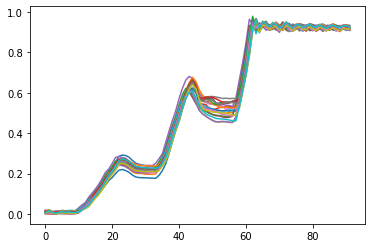

In [ ]:
for i in range(20):
 plt.plot(X_val[i])

# HP Tuning

In [ ]:
train_acc_list =[]
val_acc_list = []

# KEIN IMPURITY Decrease
def objective(trial):
      n_estimators = trial.suggest_int("n_estimators",2,300)
      max_depth = trial.suggest_int("max_depth",2,18)
      min_samples_split = trial.suggest_float("min_samples_split",0.01,0.5)
      min_samples_leaf = trial.suggest_float("min_samples_leaf",0.01,0.5)
      max_leaf_nodes = trial.suggest_int("max_leaf_nodes",2,150)
      min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf",0.01,0.3)
      max_features = trial.suggest_float("max_features",0.02,0.9)
      ccp_alpha = trial.suggest_float("ccp_alpha", 0.001,0.09)

      model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,  min_samples_split =min_samples_split,
                                     min_samples_leaf=min_samples_leaf, max_leaf_nodes=max_leaf_nodes, ccp_alpha =ccp_alpha ,
                                     min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, random_state=0)
      model.fit(X_train,y_train)
      train_predictions = model.predict(X_train)
      train_acc = accuracy_score(y_true=y_train, y_pred=train_predictions)
      train_acc_list.append(train_acc)

      val_predictions = model.predict(X_val)
      val_acc = accuracy_score(y_true=y_val, y_pred=val_predictions)
      val_acc_list.append(val_acc)
      return val_acc

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0),direction = "maximize", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=100)

[I 2022-11-20 00:45:01,722] A new study created in memory with name: no-name-b7572f48-0307-4341-8a98-45e3f5190994
[I 2022-11-20 00:45:15,718] Trial 0 finished with value: 0.5000691658597316 and parameters: {'n_estimators': 166, 'max_depth': 14, 'min_samples_split': 0.3053540542751055, 'min_samples_leaf': 0.27699275966847947, 'max_leaf_nodes': 65, 'min_weight_fraction_leaf': 0.19730929278933027, 'max_features': 0.40507674591116943, 'ccp_alpha': 0.08036779706960509}. Best is trial 0 with value: 0.5000691658597316.
[I 2022-11-20 00:45:21,073] Trial 1 finished with value: 0.5909531055471019 and parameters: {'n_estimators': 290, 'max_depth': 8, 'min_samples_split': 0.39794526866050567, 'min_samples_leaf': 0.2691585106789232, 'max_leaf_nodes': 86, 'min_weight_fraction_leaf': 0.2784230251048717, 'max_features': 0.08251173121414052, 'ccp_alpha': 0.008754507673437124}. Best is trial 1 with value: 0.5909531055471019.
[I 2022-11-20 00:45:21,156] Trial 2 finished with value: 0.49993083414026834 an

   Train   

  Train max accuracy:   0.7090091647933598 

  index of max value:   9 

  mean accuracy:   0.6189714680961439
   Validation   

  Validation max accuracy:   0.6992668418868446 

  index of max value:   9 

  mean accuracy:   0.6132701618481117


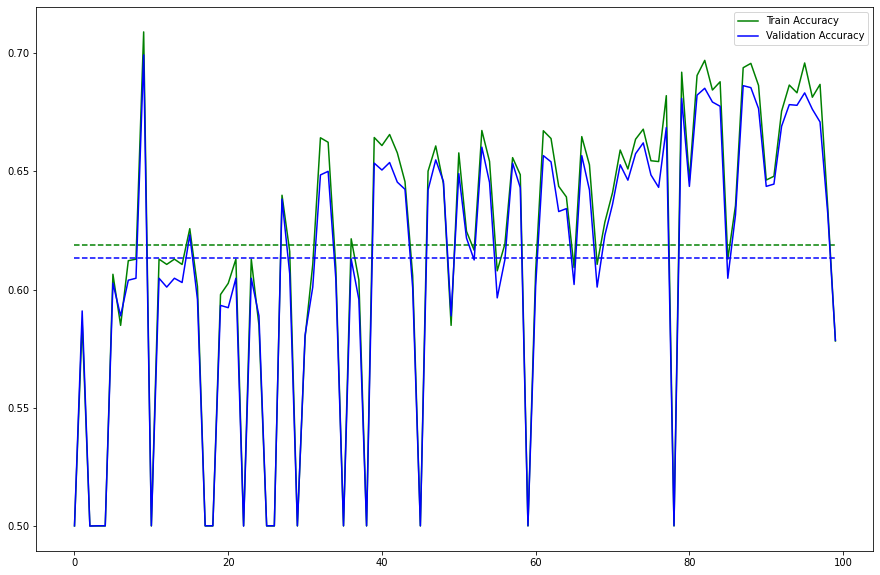

In [ ]:
plotte_acc_ergebnisse(train_acc_list, val_acc_list)

In [ ]:
strain_acc_list =[]
val_acc_list = []

def objective(trial):
     eta = trial.suggest_float("eta",1e-5,0.5)
     max_depth = trial.suggest_int("max_depth",2,32)
     gamma = trial.suggest_float("gamma",1e-2,10)
     min_child_weight = trial.suggest_float("min_child_weight",1e-3,10)
     reg_alpha = trial.suggest_float("reg_alpha",1e-2,10)
     reg_lambda = trial.suggest_float("reg_lambda",1e-2,15)
     colsample_bytree = trial.suggest_float("colsample_bytree",0.5,1)
     n_estimators = trial.suggest_int("n_estimators",10, 3000)

     model = xgb.XGBClassifier(eta=eta,
       n_estimators =n_estimators, max_depth = max_depth, gamma = gamma,
       reg_alpha = reg_alpha,min_child_weight=min_child_weight, reg_lambda=reg_lambda,
       colsample_bytree=colsample_bytree, use_label_encoder=False,
       val_metric='mlogloss',seed = 0)
     
     model.fit(X_train,y_train)
     train_predictions = model.predict(X_train)
     train_acc = accuracy_score(y_true=y_train, y_pred=train_predictions)
     train_acc_list.append(train_acc)
     val_predictions = model.predict(X_val)
     val_acc = accuracy_score(y_true=y_val, y_pred=val_predictions)
     val_acc_list.append(val_acc)
     return val_acc
    
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0),direction = "maximize", pruner=optuna.pruners.HyperbandPruner())
optimize_speicher(study,note_bookpath=notebook_path, trialanzahl_pro_study=150, anzahl_wiederholungen=20)

[I 2022-11-21 23:02:04,047] A new study created in memory with name: no-name-db79a5a4-8438-43d6-982d-a3b49e09b11e
[I 2022-11-21 23:13:46,462] Trial 0 finished with value: 0.9982016876469775 and parameters: {'eta': 0.27441126382862313, 'max_depth': 24, 'gamma': 6.031606126955722, 'min_child_weight': 5.449286946785972, 'reg_alpha': 4.242311445395658, 'reg_lambda': 9.691952754869176, 'colsample_bytree': 0.7187936056313462, 'n_estimators': 2677}. Best is trial 0 with value: 0.9982016876469775.
[I 2022-11-21 23:14:46,330] Trial 1 finished with value: 0.9983400193664407 and parameters: {'eta': 0.48183174362290965, 'max_depth': 13, 'gamma': 7.919333130445819, 'min_child_weight': 5.289420302609292, 'reg_alpha': 5.6847651653283835, 'reg_lambda': 13.88469360800699, 'colsample_bytree': 0.5355180290989434, 'n_estimators': 270}. Best is trial 1 with value: 0.9983400193664407.
[I 2022-11-21 23:24:37,992] Trial 2 finished with value: 0.997925024208051 and parameters: {'eta': 0.010118996536188456, 'ma

AUC scores: 
 0.9997306332544532 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3615
           1       1.00      1.00      1.00      3614

    accuracy                           1.00      7229
   macro avg       1.00      1.00      1.00      7229
weighted avg       1.00      1.00      1.00      7229
 

Confusion Matrix: 
 [[3602   13]
 [   8 3606]]


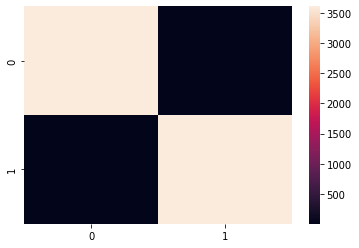

In [ ]:
model = xgb.XGBClassifier(eta=0.2280806046049521,
       n_estimators = 2049, max_depth = 19, gamma = 0.19771010635918787,
       reg_alpha = 6.124836269996989,min_child_weight=6.176737335261695, reg_lambda=9.257840613152606,
       colsample_bytree=0.9718740392573121, use_label_encoder=False,
       val_metric='mlogloss',seed = 0)

validate(model, X_val, y_val)

In [ ]:
overfitting_test(model, X_train, y_train, X_val, y_val)

Train acc:  0.9997233269929102
Test acc:  0.9980633559275142


AUC scores: 
 0.9998965532255832 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4518
           1       1.00      1.00      1.00      4518

    accuracy                           1.00      9036
   macro avg       1.00      1.00      1.00      9036
weighted avg       1.00      1.00      1.00      9036
 

Confusion Matrix: 
 [[4506   12]
 [   4 4514]]


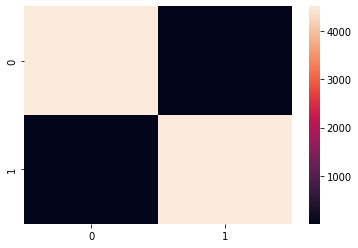

In [ ]:
validate(model, X_test, y_test)

In [ ]:
overfitting_test(model, X_train, y_train, X_test, y_test)

Train acc:  0.9997233269929102
Test acc:  0.99867197875166
